信号長 1ms でのお試し用ノート


In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from positioning.readwav import readwav
from positioning.get_spectrum_amplitude import (
    get_tukey_spectrum,
    get_tukey_spectrum_amplitude,
    get_sn_amplitude,
)
from positioning.sound_db import ReflectCeilingDB
from positioning import tools
from positioning.create_db import create_3d_spectrum_db
from positioning.estimate import estimate_direction_3d, estimate_height, calc_position
import scipy.signal as sg
from positioning.make_wave import reference_transmit_signal, reference_transmit_tukey

In [3]:
plt.style.use(["science", "notebook"])

In [4]:
signal1 = readwav("../data/pos-reflect-1ms/p28.wav")[:, 1]

In [5]:
res_signal = signal1[:240000]
first_freq: int = 15000
last_freq: int = 22000
interval_length: float = 0.1
sampling_rate = 48000  # マイクのサンプリングレート
signal_length = 0.001  # チャープ一発の信号長
interval_sample_length = int(interval_length * sampling_rate)  # チャープのバンド間の間隔のサンプル数
chirp_width = 1000  # チャープ一発の周波数帯域の幅
band_freqs = np.arange(first_freq, last_freq, chirp_width)  # 送信する周波数のバンド
sampling_buffer = 48  # データ切り出しの前後のゆとりN_c (1ms)
tukey = sg.windows.tukey(int(sampling_rate * signal_length))
# マッチドフィルター
chirp = reference_transmit_tukey(
    first_freq=first_freq,
    last_freq=last_freq,
    interval_length=interval_length,
    signal_length=signal_length,
)  # 参照信号の生成
corr = np.abs(sg.correlate(res_signal, chirp, mode="valid"))  # 相互相関
corr_lags = sg.correlation_lags(len(res_signal), len(chirp), mode="valid")
index_f = corr_lags[corr.argmax()]  # 最大値のインデックス見つける
next_peak = np.argmax(corr[index_f + 30 : index_f + 100]) + index_f + 30
diff = next_peak - index_f

<Axes: >

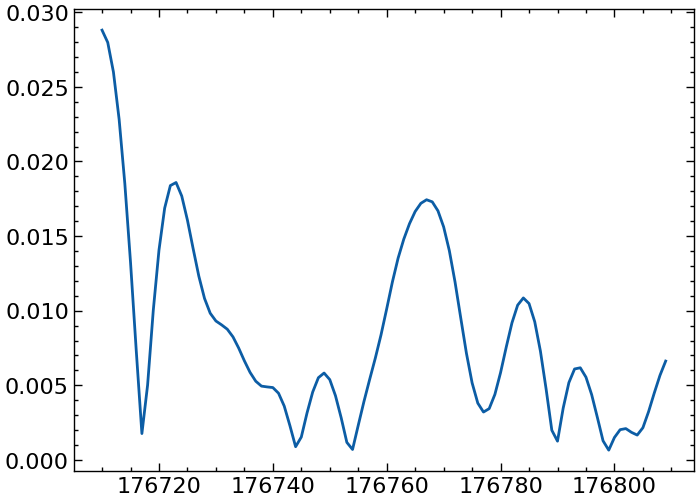

In [6]:
sns.lineplot(x=corr_lags[index_f : index_f + 100], y=corr[index_f : index_f + 100])

In [7]:
print(index_f)

176710


In [8]:
next_peak = np.argmax(corr[index_f + 30 : index_f + 100]) + index_f + 30
print(next_peak)

176767


In [9]:
def get_reflect_ceiling_tdoa(
    res_signal,
    first_freq=15000,
    last_freq=22000,
    interval_length=0.1,
    signal_length=0.001,
):
    """天井反射音の到来時間差を求める関数

    Parameters
    ----------
    res_signal : np.ndarray
        受信信号
    first_freq : int
        送信する最初の周波数
    last_freq : int
        送信する最後の周波数
    interval_length : float
        チャープのバンド間の間隔
    signal_length : float
        チャープ一発の信号長

    Returns
    -------
    int
        天井反射音の到来時間差のサンプル数
    """

    ref_transmit = reference_transmit_tukey(
        first_freq=first_freq,
        last_freq=last_freq,
        interval_length=interval_length,
        signal_length=signal_length,
    )  # 参照信号の生成
    corr = np.abs(sg.correlate(res_signal, ref_transmit, mode="valid"))  # 相互相関
    corr_lags = sg.correlation_lags(len(res_signal), len(ref_transmit), mode="valid")
    index_f = corr_lags[corr.argmax()]  # 最大値のインデックス見つける
    next_peak = np.argmax(corr[index_f + 20 : index_f + 100]) + index_f + 20
    diff = next_peak - index_f
    return diff

In [10]:
diff_samples = np.array(
    [
        get_reflect_ceiling_tdoa(
            signal1[i * 120000 : (i * 120000) + 240000],
            first_freq=1000,
            last_freq=24000,
        )
        for i in range(100)
    ]
)
print(diff_samples)

[64 63 63 64 63 63 64 63 63 64 63 63 64 63 63 64 63 64 64 63 64 63 63 64
 63 63 64 63 63 64 63 63 64 63 63 64 63 63 64 63 64 64 63 64 64 63 64 63
 63 64 63 63 64 63 63 64 63 63 64 63 63 64 63 64 64 63 64 64 63 64 63 63
 64 63 63 64 63 63 64 63 63 64 63 63 64 63 63 64 63 63 64 63 64 64 63 64
 63 63 64 63]


In [11]:
signal2 = readwav("../data/pos-reflect-1ms/p29.wav")[:, 1]

In [12]:
diff_samples = np.array(
    [
        get_reflect_ceiling_tdoa(
            signal2[i * 120000 : (i * 120000) + 240000],
            first_freq=1000,
            last_freq=24000,
        )
        for i in range(100)
    ]
)
print(diff_samples)

[62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 63 62 62 62 62
 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62]


In [13]:
signal7 = readwav("../data/pos-reflect-1ms/p34.wav")[:, 1]

In [14]:
diff_samples = np.array(
    [
        get_reflect_ceiling_tdoa(
            signal7[i * 120000 : (i * 120000) + 240000],
            first_freq=1000,
            last_freq=24000,
        )
        for i in range(100)
    ]
)
print(diff_samples)

[45 45 46 45 45 46 45 45 46 45 46 46 45 46 46 45 46 46 45 46 46 45 46 46
 45 46 45 45 46 45 45 46 45 45 46 45 45 46 45 45 46 45 45 46 45 45 46 45
 45 46 45 45 46 45 46 46 45 46 46 45 46 46 45 46 46 45 46 45 45 46 45 45
 46 45 45 46 45 45 46 45 45 46 45 45 46 45 45 46 45 45 46 45 45 46 45 45
 46 45 46 46]


In [15]:
true_pos = pd.read_csv("../data/pos-reflect-1ms/measure-points.csv", index_col=0)
r, theta, phi = tools.rect_to_polar_3d(
    true_pos["x"], true_pos["y"], true_pos["z"] - 2.2
)
true_pos["distance"] = r
true_pos["azimuth"] = theta
true_pos["elevation"] = phi
true_pos.head()

,x,y,z,distance,azimuth,elevation
p28,-0.25,1.25,1.00,1.750714,-11.309932,43.830861
p29,0.25,1.25,1.00,1.750714,11.309932,43.830861
p30,-0.25,1.75,1.00,2.136586,-8.130102,34.438989
p31,0.25,1.75,1.00,2.136586,8.130102,34.438989
p32,-0.25,1.25,1.25,1.589811,-11.309932,37.234834


In [16]:
v_distance, _, _ = tools.rect_to_polar_3d(
    true_pos["x"], true_pos["y"], true_pos["z"] - 2.8
)
true_pos["v_distance"] = v_distance
true_pos["distance_diff"] = np.abs(true_pos["distance"] - true_pos["v_distance"])
true_pos["sample_diff"] = (true_pos["distance_diff"] / 340 * sampling_rate).astype(int)
true_pos

,x,y,z,distance,azimuth,elevation,v_distance,distance_diff,sample_diff
p28,-0.25,1.25,1.000,1.750714,-11.309932,43.830861,2.205675,0.454960,64
p29,0.25,1.25,1.000,1.750714,11.309932,43.830861,2.205675,0.454960,64
p30,-0.25,1.75,1.000,2.136586,-8.130102,34.438989,2.522895,0.386309,54
p31,0.25,1.75,1.000,2.136586,8.130102,34.438989,2.522895,0.386309,54
p32,-0.25,1.25,1.250,1.589811,-11.309932,37.234834,2.006863,0.417052,58
p33,0.25,1.25,1.250,1.589811,11.309932,37.234834,2.006863,0.417052,58
p34,-0.25,1.75,1.250,2.006863,-8.130102,28.495639,2.351064,0.344200,48
p35,0.25,1.75,1.250,2.006863,8.130102,28.495639,2.351064,0.344200,48
p36,-0.25,1.25,0.750,1.930673,-11.309932,49.236395,2.414022,0.483348,68
p37,0.25,1.25,0.750,1.930673,11.309932,49.236395,2.414022,0.483348,68


In [17]:
signals = [readwav(f"../data/pos-reflect-1ms/p{i}.wav")[:, 1] for i in range(28, 42)]

In [18]:
diff_samples = np.array(
    [
        [
            get_reflect_ceiling_tdoa(
                s[i * 120000 : (i * 120000) + 240000], first_freq=1000, last_freq=24000
            )
            for i in range(100)
        ]
        for s in signals
    ]
)

In [19]:
print(diff_samples.mean(axis=1))

[63.41 62.01 54.5  54.82 57.4  35.59 45.44 45.68 69.84 69.33 57.54 58.14
 54.49 60.58]


In [20]:
db = create_3d_spectrum_db(
    "../data/reference-reflect-1ms",
    first_freq=1000,
    last_freq=24000,
    interval=0.1,
    signal_length=0.001,
)

In [21]:
est_direction = np.array(
    [
        [
            estimate_direction_3d(
                db,
                s[i * 120000 : (i + 2) * 120000],
                first_freq=1000,
                last_freq=24000,
                interval=0.1,
                signal_length=0.001,
            )
            for i in range(100)
        ]
        for s in signals
    ]
)

In [22]:
azimuth_error = np.abs(
    est_direction[:, :, 0] - true_pos["azimuth"].values.reshape(-1, 1)
)
azimuth_error.shape

(14, 100)

In [23]:
elevation_error = np.abs(
    est_direction[:, :, 1] - true_pos["elevation"].values.reshape(-1, 1)
)

In [24]:
df_est = pd.DataFrame()
for i, d in enumerate(est_direction):
    df_est = pd.concat(
        [df_est, pd.DataFrame(d, columns=["azimuth", "elevation"]).assign(test=i)]
    ).reset_index(drop=True)
df_est["azimuth_error"] = azimuth_error.reshape(-1)
df_est["elevation_error"] = elevation_error.reshape(-1)
df_est.head()

,azimuth,elevation,test,azimuth_error,elevation_error
0,-14,44,0,2.690068,0.169139
1,-14,44,0,2.690068,0.169139
2,-14,44,0,2.690068,0.169139
3,-13,44,0,1.690068,0.169139
4,-14,44,0,2.690068,0.169139


Text(9.444444444444445, 0.5, 'CDF')

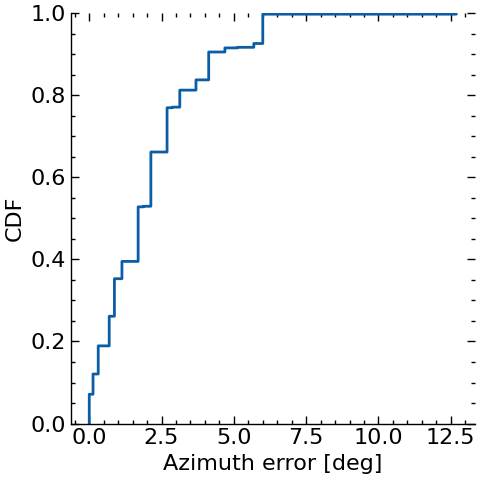

In [25]:
sns.displot(df_est, x="azimuth_error", kind="ecdf")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

Text(9.444444444444445, 0.5, 'CDF')

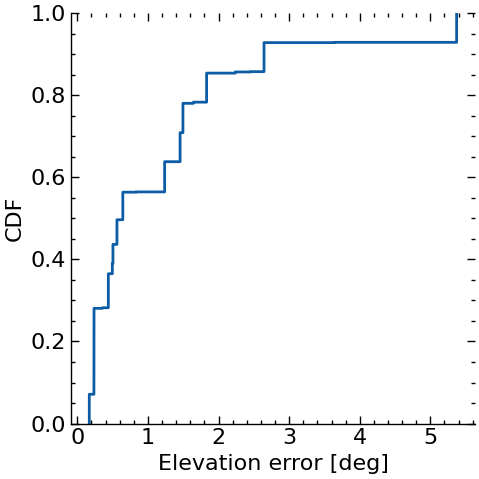

In [26]:
sns.displot(df_est, x="elevation_error", kind="ecdf")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

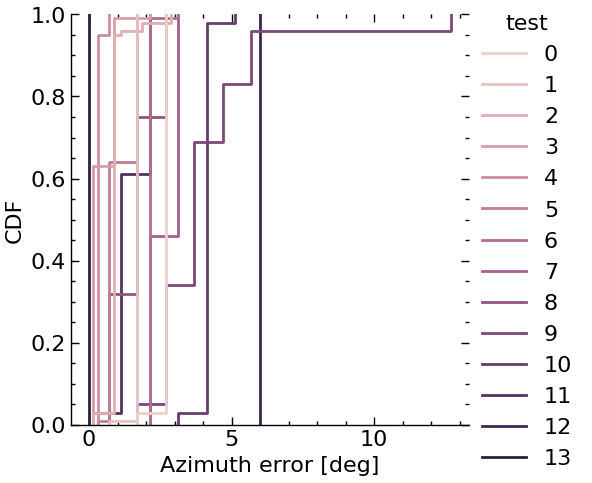

In [32]:
sns.displot(df_est, x="azimuth_error", kind="ecdf", hue="test")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

Text(21.443965277777778, 0.5, 'CDF')

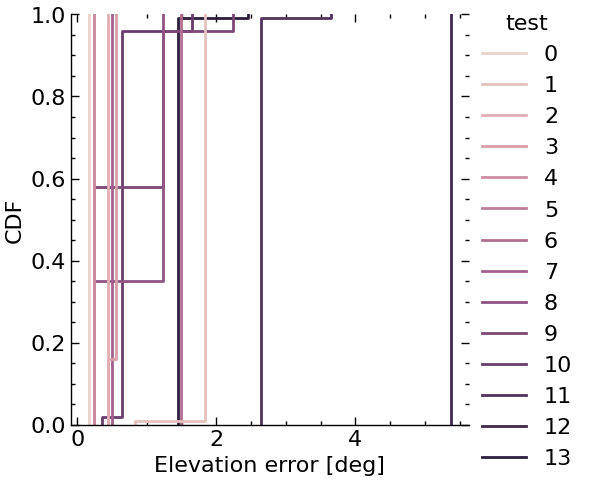

In [33]:
sns.displot(df_est, x="elevation_error", kind="ecdf", hue="test")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

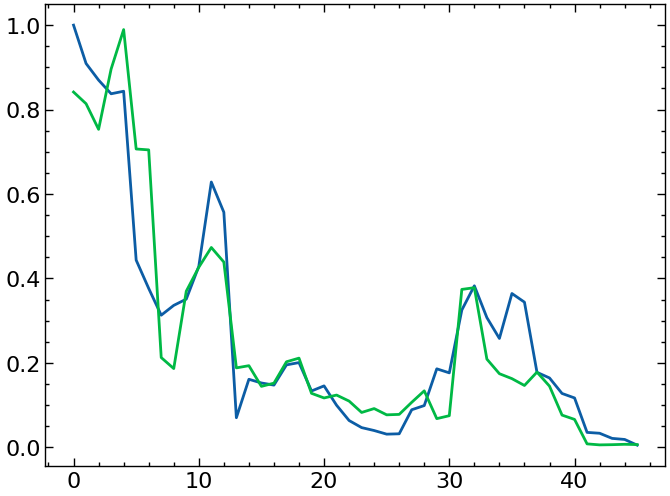

In [29]:
plt.plot(db[10, 30, :])
plt.plot(db[39, 23, :])

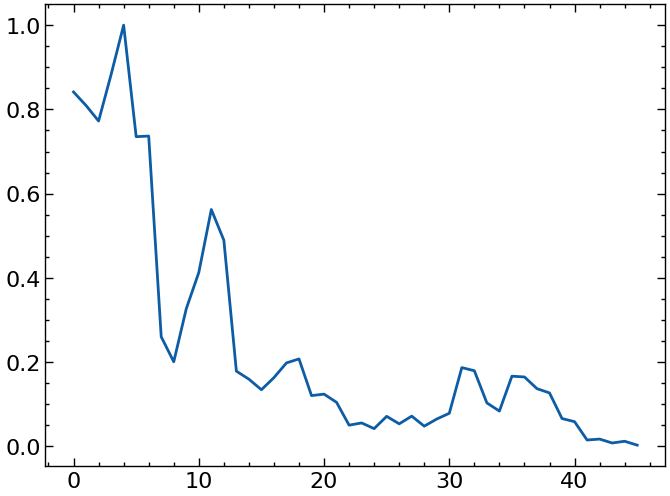

In [31]:
plt.plot(get_tukey_spectrum(signals[0][:240000], 1000, 24000, 0.1, 0.001))

1~24kHz 全部使ってみたら性能良さそうなので測位の実装してみる


In [34]:
import sympy

In [51]:
def positioning_direction_reflect_tdoa(azimuth, elevation, tdoa_sample):
    """方位角、仰角、天井反射の到来時間差から測位する関数
    スピーカーが天井から30cmの位置にある設定

    Parameters
    ----------
    azimuth : float
        方位角 [deg]
    elevation : float
        仰角 [deg]
    tdoa_sample : int
        天井反射の到来時間差 [sample]

    Returns
    -------
    NDArray
        推定位置(x, y, z)[m]
    """

    sampling_rate = 48000  # マイクのサンプリングレート
    speaker_height = 2.2  # スピーカーの高さ
    speaker_ceiling_distance = 0.3  # スピーカーと天井の距離
    diff_distance = tdoa_sample / sampling_rate * 340  # 天井反射の到来時間差から距離差を計算
    r = sympy.Symbol("r")
    x = sympy.Symbol("x")
    y = sympy.Symbol("y")
    z = sympy.Symbol("z")
    expr1 = r * np.cos(np.radians(elevation)) * np.sin(np.radians(azimuth)) - x
    expr2 = r * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth)) - y
    expr3 = r * np.sin(np.radians(elevation)) - z
    expr4 = (
        (x**2 + y**2 + (z - (speaker_height + (speaker_ceiling_distance * 2))) ** 2)
        ** 0.5
        - (x**2 + y**2 + (z - speaker_height) ** 2) ** 0.5
        - diff_distance
    )
    sol = sympy.solve([expr1, expr2, expr3, expr4], [x, y, z, r])
    if sol[0][3] > 0:
        return np.array([sol[0][0], sol[0][1], sol[0][2]])
    return np.array([sol[1][0], sol[1][1], sol[1][2]])

In [52]:
tmp = positioning_direction_reflect_tdoa(-11, 44, 64)

In [53]:
print(tmp)

[-0.223409452633031 1.14934199674899 1.13068044914633]


In [54]:
df_est["tdoa"] = diff_samples.reshape(-1)
df_est.head()

,azimuth,elevation,test,azimuth_error,elevation_error,tdoa,x,y,z,position_error
0,-14,44,0,2.690068,0.169139,64,-0.283255190192731,1.13607451615007,1.13068044914633,0.176528
1,-14,44,0,2.690068,0.169139,63,-0.288839928754702,1.15847367909321,1.15297326115559,0.182446
2,-14,44,0,2.690068,0.169139,63,-0.288839928754702,1.15847367909321,1.15297326115559,0.182446
3,-13,44,0,1.690068,0.169139,64,-0.263384814856396,1.14084497120328,1.13068044914633,0.170796
4,-14,44,0,2.690068,0.169139,63,-0.288839928754702,1.15847367909321,1.15297326115559,0.182446


In [55]:
for i, est in df_est.iterrows():
    pos = positioning_direction_reflect_tdoa(
        est["azimuth"], est["elevation"], est["tdoa"]
    )
    df_est.at[i, "x"] = pos[0]
    df_est.at[i, "y"] = pos[1]
    df_est.at[i, "z"] = pos[2]
    pos_error = np.linalg.norm(
        pos.astype("float")
        - true_pos.loc[f'p{est["test"] + 28}', ["x", "y", "z"]].to_numpy()
    )
    df_est.at[i, "position_error"] = pos_error
df_est.head()

,azimuth,elevation,test,azimuth_error,elevation_error,tdoa,x,y,z,position_error
0,-14,44,0,2.690068,0.169139,64,-0.283255190192731,1.13607451615007,1.13068044914633,0.176528
1,-14,44,0,2.690068,0.169139,63,-0.288839928754702,1.15847367909321,1.15297326115559,0.182446
2,-14,44,0,2.690068,0.169139,63,-0.288839928754702,1.15847367909321,1.15297326115559,0.182446
3,-13,44,0,1.690068,0.169139,64,-0.263384814856396,1.14084497120328,1.13068044914633,0.170796
4,-14,44,0,2.690068,0.169139,63,-0.288839928754702,1.15847367909321,1.15297326115559,0.182446


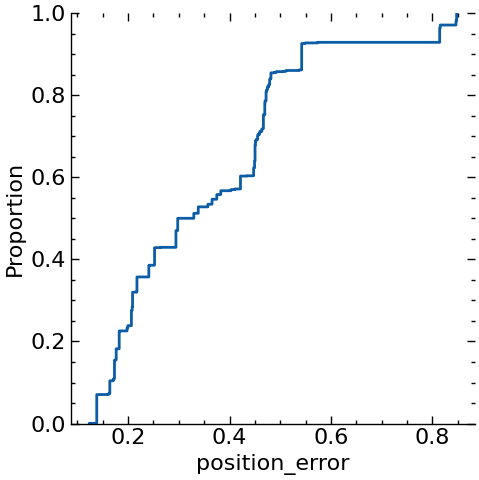

In [56]:
sns.displot(df_est, x="position_error", kind="ecdf")

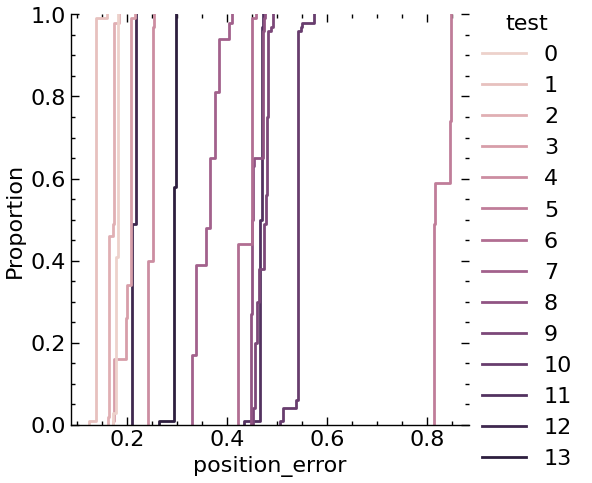

In [57]:
sns.displot(df_est, x="position_error", kind="ecdf", hue="test")